In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import cm
mpl.rcParams['figure.dpi'] = 200


from hyperion.models.photon_arrival_time.pdf import make_exp_exp_exp, make_obj_func, sample_exp_exp_exp, fb5_mle
from hyperion.models.photon_arrival_time.net import PhotonArivalTimePars
from hyperion.utils import cherenkov_ang_dist, ANG_DIST_INT, calc_tres
import pickle
from torch.utils.data import DataLoader

from tqdm.notebook import trange, tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

import torch.optim as optim
%matplotlib inline

from glob import glob
import json

from train_net import make_funnel

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")






In [3]:
det_r = 0.21
medium = json.load(open("hyperion/resources/medium.json"))

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


[]

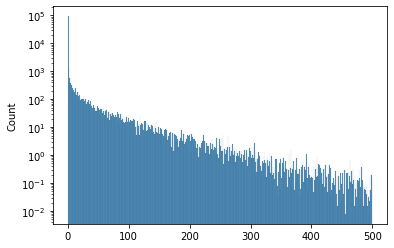

In [4]:
det_ph = pickle.load(open("data/photon_table_1.pickle", "rb"))
sim_data = det_ph[0]


c_medium = 0.299792458 / medium["n_ph"]
tres = calc_tres(sim_data["times_det"], 0.21, sim_data["dist"], c_medium)
weights = np.exp(-sim_data["times_det"] *c_medium / medium["abs_len"])

c_weight = cherenkov_ang_dist(np.cos(sim_data["emission_angles"]-0)) / ANG_DIST_INT *2
tot_weight = weights * c_weight


hist, _ = np.histogram(tres, weights=tot_weight, bins= np.linspace(0, 500, 500))

sns.histplot(x=tres, weights=tot_weight, bins=np.linspace(0, 500, 500), stat="count", 
             label=f"Obs. Angle 0 deg")
plt.semilogy()

In [5]:
class SimpleDataset(Dataset):
    """Simple Dataset subclass that returns a tuple (input, output)."""

    def __init__(self, inputs, outputs):
        super(SimpleDataset, self).__init__()
        self._inputs = inputs
        self._outputs = outputs

        if len(self._inputs) != len(self._outputs):
            raise ValueError("Inputs and outputs must have same length.")

        self._len = len(self._inputs)

    def __getitem__(self, idx):
        """Return tuple of input, output."""
        return self._inputs[idx], self._outputs[idx]

    def __len__(self):
        return self._len

In [6]:
def train_net(conf, train_data, test_data, writer, seed=31337):
    g = torch.Generator()
    torch.random.manual_seed(seed)
    g.manual_seed(seed)

    train_loader = DataLoader(
        train_data,
        batch_size=conf["batch_size"],
        shuffle=True,
        # worker_init_fn=seed_worker,
        generator=g,
    )
    test_loader = DataLoader(
        test_data,
        batch_size=conf["batch_size"],
        shuffle=False,
        # worker_init_fn=seed_worker,
        generator=g,
    )

    layers = [conf["n_neurons"], conf["n_neurons"], conf["n_neurons"]]

    net = PhotonArivalTimePars(
        layers,
        conf["n_in"],
        conf["n_out"],
        dropout=conf["dropout"],
        final_activations=conf["final_activations"],
    ).to(device)
    optimizer = optim.Adam(net.parameters(), lr=conf["lr"])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, conf["epochs"])

    def criterion(pred, target):
        # print(pred.shape, target.shape)
        not_nan = torch.isfinite(target)
        mse = torch.mean((pred[not_nan] - target[not_nan]) ** 2, axis=0)
        return mse

    
    """
    def criterion(pred, target):
        not_nan = torch.isfinite(target)
        poisson = -torch.exp(target[not_nan]) + torch.exp(pred[not_nan]) * target[not_nan]
        return poisson
    """

    for epoch in range(conf["epochs"]):
        total_train_loss = 0
        for train in train_loader:
            net.train()
            optimizer.zero_grad()
            inp, out = train
            pred = net(inp)


            loss = criterion(pred, out)
            loss = loss.sum()
            loss.backward()

            total_train_loss += loss.item() * inp.shape[0]

            optimizer.step()

        total_train_loss /= len(train_data)

        total_test_loss = 0
        for test in test_loader:
            net.eval()

            inp, out = test
            pred = net(inp)

            loss = criterion(pred, out)
            loss = loss.sum()

            total_test_loss += loss.item() * inp.shape[0]

        total_test_loss /= len(test_data)

        if writer is not None:
            writer.add_scalar("Loss/train", total_train_loss, epoch)
            writer.add_scalar("Loss/test", total_test_loss, epoch)
            writer.add_scalar("LR", optimizer.param_groups[0]["lr"], epoch)

        scheduler.step()
    
    
    if writer is not None:
        net.eval()

        inp, out = test_data[:]
        pred = net(inp)

        loss = criterion(pred, out)
        loss = loss.sum() / len(test_data)

        hparam_dict = dict(conf)
        del hparam_dict["final_activations"]
        writer.add_hparams(hparam_dict, {"hparam/test_loss": loss.item()})
        writer.flush()
        writer.close()
        
    return net


In [7]:

#for tts in [2, 3, 4]:
for tts in [0]:
    hists = pickle.load(open(f"data/combined_photon_hists_{tts}.pickle", "rb"))
    inputs = torch.tensor(hists[::2], dtype=torch.float, device=device)
    outputs = torch.tensor(hists[1::2], dtype=torch.float, device=device)
    inputs = inputs.reshape((inputs.shape[0] * inputs.shape[1], 2))
    outputs = outputs.reshape((outputs.shape[0] * outputs.shape[1], 529))

    """
    bin_width = 1 # ns
    noise_rate = 1E3 * 16 / 1E9
    noise_hits =  noise_rate * bin_width

    outputs += noise_hits
    """
    outputs = torch.log(outputs)

    first_finite = torch.nonzero(torch.sum(~torch.isfinite(outputs), axis=0) / outputs.shape[0] < 0.5)[0]
    outputs[:, :first_finite] = -300
    print(first_finite)
    #binning = torch.arange(-30+first_finite.item(), 500, 1)
    #outputs = outputs[:, first_finite:]
    #print(first_finite)

    binning = torch.arange(-30, 500, 1)
    
    
    
    inputs[:, 1] = torch.log10(inputs[:, 1])
    data = SimpleDataset(inputs, outputs)
    split = int(0.5*len(data))
    train_data, test_data = torch.utils.data.random_split(data, [split, len(data)-split])


    conf = {
            "batch_size" : 500,
            "n_in": 2,
            "n_out": outputs.shape[1],
            "dropout": 0.2,
            "final_activations": [nn.Identity()]*outputs.shape[1],
            "lr": 0.001,
            "epochs": 900,
            "n_neurons": 1500
        }
    writer = SummaryWriter(
        f"/tmp/tensorboard/runs/hist_test_{conf['batch_size']}_{conf['lr']}_{conf['epochs']}_{conf['dropout']}_{conf['n_neurons']}"
    )




    net = train_net(conf, train_data, test_data, writer)
    torch.save([net, binning], f"data/arrival_hist_net_{tts}tts.dat")


tensor([29], device='cuda:0')


In [116]:
for n_neurons in [1500, 1800]:
    for epochs in [900]:
        for lr in [0.001]:
            for dropout in [0, 0.1, 0.2, 0.5]:
                conf = {
                    "batch_size" : 500,
                    "n_in": 2,
                    "n_out": 499,
                    "dropout": dropout,
                    "final_activations": [nn.Identity()]*499,
                    "lr": lr,
                    "epochs": epochs,
                    "n_neurons": n_neurons
                }
            writer = SummaryWriter(
                f"/tmp/tensorboard/runs/hist_test_{conf['batch_size']}_{conf['lr']}_{conf['epochs']}_{conf['dropout']}_{conf['n_neurons']}"
            )

        train_net(conf, train_data, test_data, writer)
            



KeyboardInterrupt: 

In [42]:
!rm -rf /tmp/tensorboard/runs/*

tensor([-1], device='cuda:0')

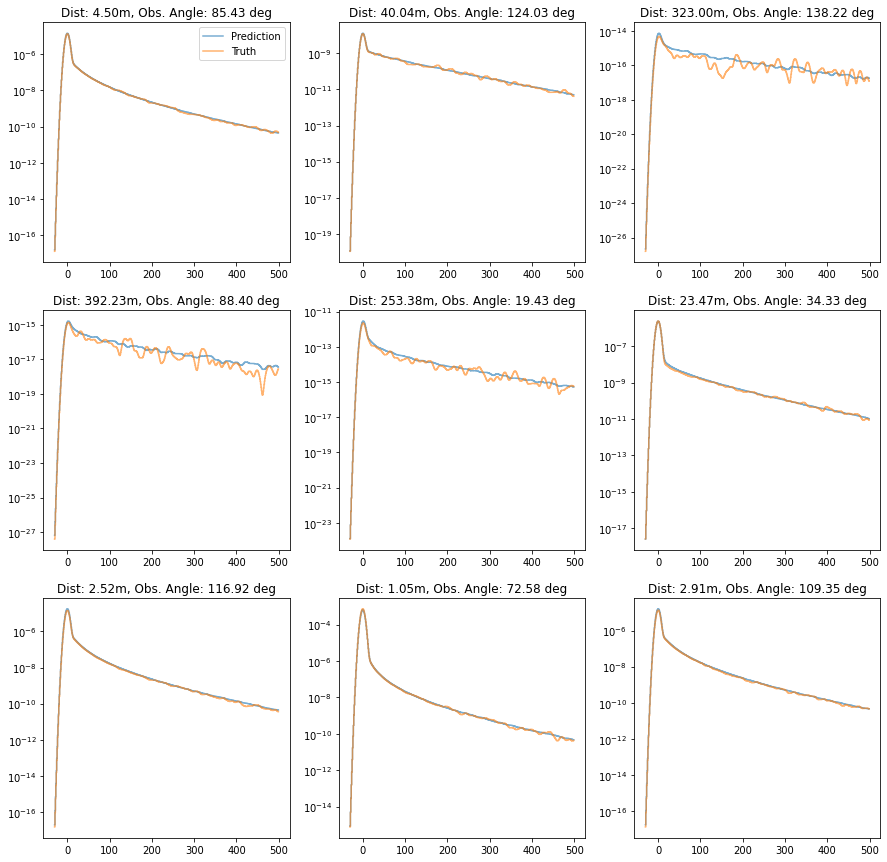

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

rng = np.random.RandomState(9)

ixs = rng.choice(len(test_data), size=9)
net.eval()


for ax, ix in zip(axs.ravel(), ixs):

    net_in = test_data[ix][0][np.newaxis, :]
    nn_out = net(net_in)[0].detach().cpu().numpy()
    truth = test_data[ix][1].detach().cpu().numpy()
    ax.step(binning, np.exp(np.append(nn_out, nn_out[-1])), alpha=0.6, label="Prediction", where="post")
    ax.step(binning, np.exp(np.append(truth, truth[-1])), alpha=0.6, label="Truth", where="post")

    ax.set_yscale("log")
    ax.set_title(f"Dist: {10**net_in[0][1].cpu():.2f}m, Obs. Angle: {np.degrees(net_in[0][0].cpu()):.2f} deg")
    #ax.set_xlim(-5, 20)
    axs[0][0].legend()
    #ax.set_ylim(1E-12, 1E-3)

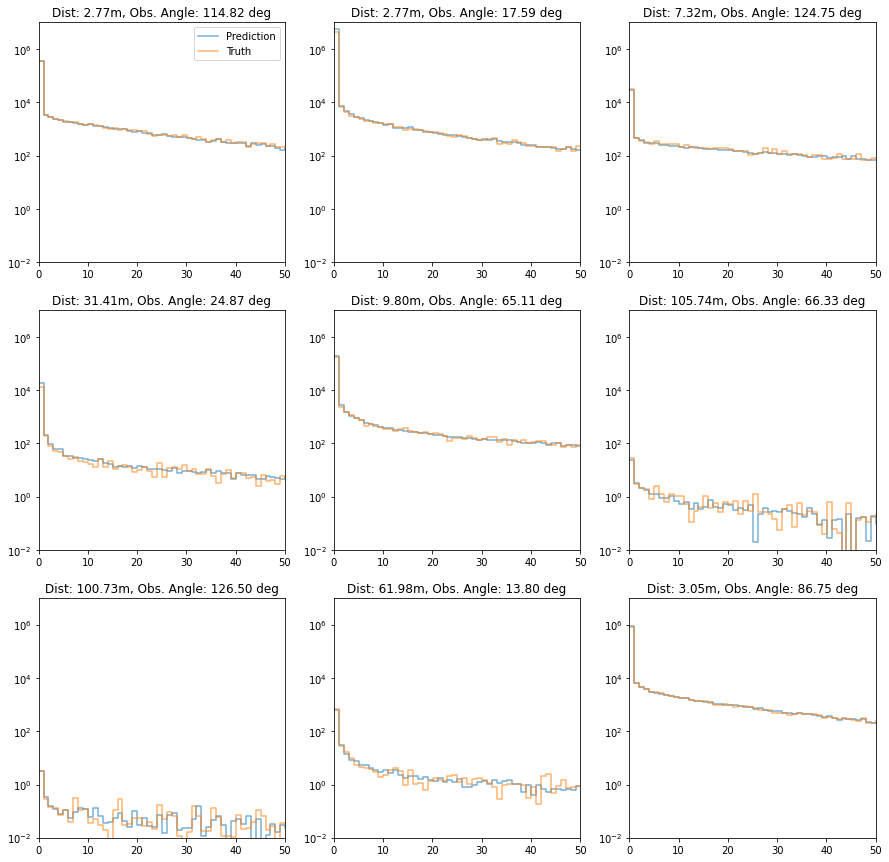

In [235]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

rng = np.random.RandomState(0)

ixs = rng.choice(len(test_data), size=9)

net.eval()
binning = np.linspace(0, 500, 500)

for ax, ix in zip(axs.ravel(), ixs):

    net_in = test_data[ix][0][np.newaxis, :]
    nn_out = net(net_in)[0].detach().cpu().numpy()
    truth = test_data[ix][1].detach().cpu().numpy()
    ax.step(binning, 10**np.append(nn_out, nn_out[-1]), alpha=0.6, label="Prediction", where="post")
    ax.step(binning, 10**np.append(truth, truth[-1]), alpha=0.6, label="Truth",  where="post")

    ax.set_yscale("log")
    ax.set_ylim(1E-2, 1E7)
    ax.set_title(f"Dist: {10**net_in[0][1].cpu():.2f}m, Obs. Angle: {np.degrees(net_in[0][0].cpu()):.2f} deg")
    ax.set_xlim(0, 50)
axs[0][0].legend()
    

In [9]:
net = torch.load("data/arrival_hist_net.dat")

[]

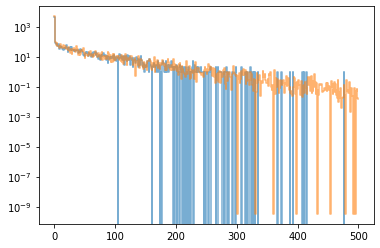

In [20]:
from hyperion.models.binned.binned import sample_poisson
gen = torch.Generator(device=torch.device("cuda"))
net_in = test_data[0][0][np.newaxis, :]
binning = np.linspace(0, 500, 500)
fig, ax = plt.subplots()
pred = sample_poisson(net, net_in, gen).detach().cpu().numpy()[0]
truth = test_data[0][1].detach().cpu().numpy()
ax.step(binning, np.append(pred, pred[-1]), alpha=0.6, label="Prediction", where="post")
ax.step(binning, 10**np.append(truth, truth[-1]), alpha=0.6, label="Truth",  where="post")
plt.semilogy()

In [ ]:
from gnn_testbed.event_generation.photon_propagation import source_to_model_input,